In [26]:
#!/usr/bin/env python
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import re
import os
os.chdir('D://scratch_backup//alpine//beri9208//mnc-pt-pyrid_direct//PtScan//4n//No_bias_corrected//z0_reqfiles')

#These functions return 1 for fractional coordinates that are within the desired regions:
def atomWeightMo(pos):
	return 1. if (pos[2]>+0.21) else 0. #selects surface Mo
def atomWeightP(pos):
	return 1. if (pos[2]<-0.21) else 0. #selects surface P

Pt_center = [0.43333, 0.46668, 0.52023]
def relDist(pos1, pos2):
	return abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])
cutoff = 0.2
def atomWeightCenter(pos):
	return 1. if (relDist(pos, Pt_center) < cutoff ) else 0.
def atomWeightOuter(pos):
	return 1. if (relDist(pos, Pt_center) > cutoff ) else 0.

#Helper function to plot colormapped lines:
def plotCmapped(x, y, w, cmap='Greys', lw=2):
	for iCol in range(y.shape[1]):
		yCur = y[:,iCol]
		wCur = w[:,iCol]
		#Get segments to plot as line collection:
		points = np.array([x, yCur]).T.reshape(-1, 1, 2)
		segments = np.concatenate([points[:-1], points[1:]], axis=1)
		lc = LineCollection(segments, cmap=cmap, lw=lw, norm=plt.Normalize(0, 1))
		#Set cmap array and add to plot:
		lc.set_array(0.5*(wCur[:-1]+wCur[1:]) + 0.1)
		plt.gca().add_collection(lc)

#Energy ranges for the plots:
eV = 1/27.2114
VBM = -0.170341 #or mu as the case may be
Emin_eV = -2. #in eV relative to VBM/mu
Emax_eV = +2. #in eV relative to VBM/mu

In [27]:
#Extract geometry from totalE.out:
iLine = 0
refLine = -10
R = np.zeros((3,3))
Rdone = False
ionPosStarted = False
ionNames = []
ionPos = []
for line in open('out'):
	#Lattice vectors:
	if line.find('Initializing the Grid') >= 0 and (not Rdone):
		refLine = iLine
	rowNum = iLine - (refLine+2)
	if rowNum>=0 and rowNum<3:
		R[rowNum,:] = [ float(x) for x in line.split()[1:-1] ]
	if rowNum==3:
		refLine = -10
		Rdone = True
	#Coordinate system and ionic positions:
	if ionPosStarted:
		tokens = line.split()
		if len(tokens) and tokens[0] == 'ion':
			ionNames.append(tokens[1])
			ionPos.append([float(tokens[2]),float(tokens[3]),float(tokens[4])])
		else:
			break
	if line.find('# Ionic positions in') >= 0:
		coords = line.split()[4]
		ionPosStarted = True
	#Line counter:
	iLine += 1

In [28]:
verbose = True
#Switch atoms to lattice coordinates:
ionPos = np.array(ionPos)
if coords != 'lattice':
	ionPos = np.dot(ionPos, np.linalg.inv(R.T)) #convert to lattice

#Read projection file:
for iLine,line in enumerate(open('bandProjections')):
	tokens = line.split()
	if iLine==0:
		if verbose: print('line0 as tokens: ' + str(tokens))
		nStates = int(tokens[0])
		nBands = int(tokens[2])
		nProj = int(tokens[4])
		print('# of projections per state and band: ' + str(nProj))
		nSpecies = int(tokens[6])
		proj = np.zeros((nStates,nBands,nProj))
		nOrbsPerAtom = [] #number of orbitals per atom
	elif iLine>=2:
		print('iLine=' + str(iLine))
		if iLine<nSpecies+2:
			print('passed first conditional')
			print('all tokens: ' + str(tokens))
			nAtoms = int(tokens[1])
			nOrbsPerAtom.extend( [int(tokens[2]),] * nAtoms )
			print('orbs per atom updated: ' + str(nOrbsPerAtom))
		else:
			print('didnt pass first conditional')
			iState = (iLine-(nSpecies+2)) // (nBands+1)
			print('iState: ' + str(iState))
			iBand = (iLine-(nSpecies+2)) - iState*(nBands+1) - 1 # This negative one makes the header line become iBand=-1
			print('iBand: ' + str(iBand))
			# if iBand < 0:
			# 	print('tokens for negative band (?)')
			# 	print(tokens)
			if iBand>=0 and iState<nStates:
				print('computed projections for iBand ' + str(iBand) + ', iState ' + str(iState) + ' length: ')
				print(len(tokens))
				proj[iState,iBand] = np.array([float(tok) for tok in tokens])
	print('---------------------------------')

line0 as tokens: ['8', 'states,', '127', 'bands,', '204', 'orbital-projections,', '3', 'species']
# of projections per state and band: 204
---------------------------------
---------------------------------
iLine=2
passed first conditional
all tokens: ['C', '44', '4', '1', '1', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
---------------------------------
iLine=3
passed first conditional
all tokens: ['N', '4', '4', '1', '1', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
---------------------------------
iLine=4
passed first conditional
all tokens: ['Pt', '1', '12', '2', '1', '2', '1']
orbs per atom updated: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [29]:
#Create orbital weights from atom weights:
orbWeightsCenter = []
orbWeightsOuter = []
for iAtom,pos in enumerate(ionPos):
	orbWeightsCenter.extend( [atomWeightCenter(pos),] * nOrbsPerAtom[iAtom] )
	orbWeightsOuter.extend( [atomWeightOuter(pos),] * nOrbsPerAtom[iAtom] )
orbWeightsCenter = np.array(orbWeightsCenter)
orbWeightsOuter = np.array(orbWeightsOuter)

#Compute band weights based on orbWeights:
weightsCenter = np.dot(proj, orbWeightsCenter) / np.sum(proj, axis=-1)
weightsOuter = np.dot(proj, orbWeightsOuter) / np.sum(proj, axis=-1)

#Read bandstruct eigenvalues:
E = np.fromfile('eigenvals').reshape((nStates,nBands))

['', 's', 'e', 't', '', 'x', 't', 'i', 'c', 's', '', '(', '', 'G', 'a', 'm', 'm', 'a', '', '0', '', 'P', '1', '', '5', '', 'P', '2', '', '1', '0', '', 'P', '3', '', '1', '5', '', 'G', 'a', 'm', 'm', 'a', '', '2', '4', '', 'P', '4', '', '2', '9', '', ')', '\n', '']


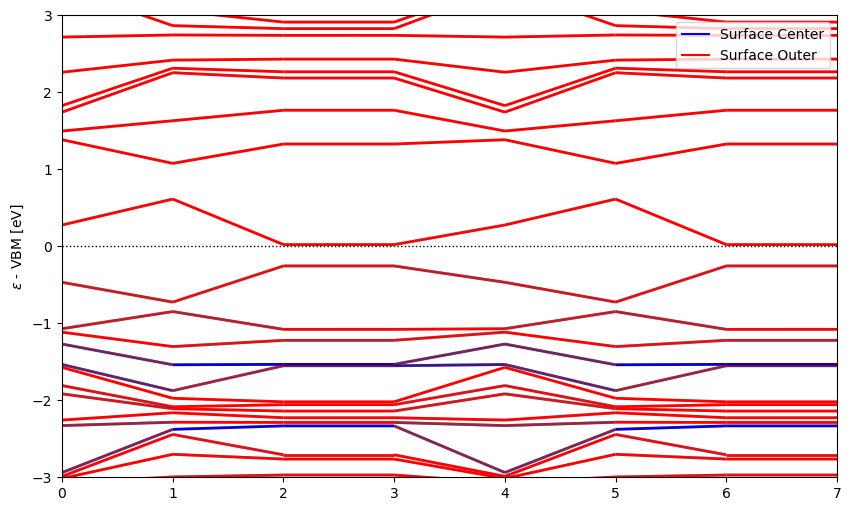

In [31]:

#Construct custom colormap:
t = np.linspace(0., 1., 256)[:,None]
color0 = np.array([0.,0.,0., 0.01]) #RGBA color corresponding to zero weight
colorMo = np.array([0.,0.,1., 1.]) #RGBA color corresponding to full weight for surface Mo
colorP = np.array([1.,0.,0., 1.]) #RGBA color corresponding to full weight for surface P
cmapMo = ListedColormap(color0[None,:]*(1.-t) + colorMo[None,:]*t)
cmapP = ListedColormap(color0[None,:]*(1.-t) + colorP[None,:]*t)

#Plot band structure:
plt.figure(1, figsize=(10,6))
plotCmapped(np.arange(nStates), (E-VBM)/eV, weightsCenter, cmap=cmapMo)
plotCmapped(np.arange(nStates), (E-VBM)/eV, weightsOuter, cmap=cmapP)
plt.xlim(0, nStates-1)
plt.ylim(-3, 3)
plt.ylabel(r'$\varepsilon$ - VBM [eV]')
plt.axhline(0., lw=1, color='k', ls='dotted')
#--- read and add plot labels:
for line in open('bandstruct.plot'):
	if line.startswith('set xtics'):
		tokens = re.split('[ ,"]*', line)
		print(tokens)
		xticLabels = ['Gamma', 'P1', 'P2', 'P3', 'Gamma', 'P4']
#		xticLabels = [ (r'$\Gamma$' if token=='Gamma' else token) for token in tokens[3:-1:2] ]
		xticPos = [0, 5, 10, 15, 24, 29]
		# xticPos = [ int(token) for token in tokens[4:-1:2] ]
#		plt.xticks(xticPos, xticLabels)

plt.legend([
	Line2D([0], [0], color=cmapMo(1.)),
	Line2D([0], [0], color=cmapP(1.))  ], ['Surface Center', 'Surface Outer'])

#plt.savefig('weightedBandstruct.pdf', bbox_inches='tight')
plt.show()